In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
################################################################################
# Inicialización de los generadores de números aleatorios para reproducibilidad
# Valor de la semilla inicial
seed_value= 1

# 1. Definir la variable de entorno `PYTHONHASHSEED` a un valor dado
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Iniciar el generador de número aleatorios en `python`
# módulo random
import random
random.seed(seed_value)

# 3. Iniciar el generador de número aleatorios de `numpy`
import numpy as np
np.random.seed(seed_value)

# 4. Iniciar el generador de número aleatorios de `tensorflow`
import tensorflow as tf
tf.random.set_seed(seed_value) #tf.random.set.seed(seed_value)
################################################################################


In [8]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import h5py
import keras
from tensorflow.keras.models import load_model
from tensorflow.keras import applications

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D,GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.applications.imagenet_utils import preprocess_input

from keras.callbacks import EarlyStopping

# Usamos un drive compartido, entonces la ruta al dataset depende de quien ejecute el codigo.
USUARIO = 'Lolo'
if USUARIO =='Fer':
  base_dir = "/content/drive/MyDrive/Trabajo_TL/datos"
elif USUARIO =='Lolo':
  base_dir = "/content/drive/MyDrive/Colab Notebooks/datos"

train_dir =      os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'valid')
test_dir =       os.path.join(base_dir, 'test')

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input as preprocess_input_vgg16

# Selección de la red pre-entrenada

#RED_TRANSFER='vgg16'
#RED_TRANSFER = 'MobileNet'
RED_TRANSFER = 'EfficientNetB0'

# Resize 197x197, tamaño mínimo de la imagen para ResNet
ROWS = 224
COLS = 224

n_batches = 32

if (RED_TRANSFER=='vgg16'):
  preprocess = preprocess_input_vgg16
elif(RED_TRANSFER=='EfficientNetB0'):
  preprocess = applications.efficientnet.preprocess_input
elif(RED_TRANSFER=='MobileNet'):
  preprocess = applications.mobilenet.preprocess_input

train_datagen = ImageDataGenerator(
    preprocessing_function = preprocess)

validation_datagen  = ImageDataGenerator(
    preprocessing_function = preprocess)

test_datagen  = ImageDataGenerator(
    preprocessing_function = preprocess)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=n_batches,
                                                    class_mode='categorical',
                                                    target_size=(ROWS, COLS))

validation_generator =  validation_datagen.flow_from_directory(validation_dir,
                                                         batch_size=n_batches,
                                                         class_mode  = 'categorical',
                                                         target_size=(ROWS, COLS))


test_generator =  test_datagen.flow_from_directory(test_dir,
                                                         shuffle=False,
                                                         batch_size=n_batches,
                                                         class_mode  = 'categorical',
                                                         target_size=(ROWS, COLS))


Found 7624 images belonging to 53 classes.
Found 265 images belonging to 53 classes.
Found 265 images belonging to 53 classes.


In [9]:
# Congelamos todas las capas excepto las fully connected
# En el caso de la ResNet hay capas de Normalización que hay que dejar
# como entrenables

img_height,img_width = ROWS,COLS
num_classes = 53

if RED_TRANSFER=='vgg16':
    Red=applications.vgg16.VGG16(include_top=False,
              weights='imagenet', pooling='max', input_shape=(img_height,img_width , 3 ) )
    for layer in Red.layers:
        layer.trainable = False
    for layer in Red.layers:
        print(layer, layer.trainable)
elif RED_TRANSFER == 'MobileNet':
    Red=applications.MobileNet(include_top=False,
              weights='imagenet', input_shape=(img_height,img_width , 3 ) )
    for layer in Red.layers:
        layer.trainable = False
    for layer in Red.layers:
        if 'BatchNormalization' in str(layer):
            layer.trainable = True
        print(layer, layer.trainable)
elif RED_TRANSFER == 'EfficientNetB0':
    Red = applications.EfficientNetB0(include_top=False,
              weights='imagenet', input_shape=(img_height,img_width , 3 ) )
    for layer in Red.layers:
        layer.trainable = False
    for layer in Red.layers:
        if 'BatchNormalization' in str(layer):
            layer.trainable = True
        print(layer, layer.trainable)


model = Sequential()
model.add(Red)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

<keras.src.engine.input_layer.InputLayer object at 0x7cd84e532b00> False
<keras.src.layers.preprocessing.image_preprocessing.Rescaling object at 0x7cd84e533460> False
<keras.src.layers.preprocessing.normalization.Normalization object at 0x7cd8d45ce590> False
<keras.src.layers.preprocessing.image_preprocessing.Rescaling object at 0x7cd8547b8490> False
<keras.src.layers.reshaping.zero_padding2d.ZeroPadding2D object at 0x7cd966ffa1d0> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7cd8d46b2380> False
<keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x7cd8d46b2050> True
<keras.src.layers.core.activation.Activation object at 0x7cd8d46b2f20> False
<keras.src.layers.convolutional.depthwise_conv2d.DepthwiseConv2D object at 0x7cd84e304df0> False
<keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x7cd8d50b5f00> True
<keras.src.layers.core.activation.Activation object at 0x7cd84e533df0> False
<keras.src.layers.pooling

In [10]:
from tensorflow.keras.optimizers import SGD, Adam
adam = Adam(learning_rate=0.001)
model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])

# Añadimos early stopping
early_stop = EarlyStopping(patience = 2, verbose = 1, monitor='val_accuracy' , mode='max', min_delta=0.001, restore_best_weights = True)
callbacks = [early_stop]

history=model.fit(train_generator, epochs = 20,
                  validation_data  = validation_generator,
                  callbacks = callbacks,
                  verbose=1
                  )
if USUARIO='Fer'
  if RED_TRANSFER=='vgg16':
      model.save_weights('/content/drive/MyDrive/Trabajo_TL/model_vgg16.h5')
  elif RED_TRANSFER=='MobileNet':
      model.save_weights('/content/drive/MyDrive/Trabajo_TL/model_MobileNet.h5')
  elif RED_TRANSFER=='EfficientNetB0':
      model.save_weights('/content/drive/MyDrive/Trabajo_TL/model_EfficientNetB0.h5')

Epoch 1/20
239/239 [==============================] - ETA: 0s - loss: 2.8767 - accuracy: 0.3682 

239/239 [==============================] - 2549s 11s/step - loss: 2.8767 - accuracy: 0.3682 - val_loss: 1.2571 - val_accuracy: 0.6453
Epoch 2/20
239/239 [==============================] - ETA: 0s - loss: 1.3560 - accuracy: 0.6444

239/239 [==============================] - 56s 235ms/step - loss: 1.3560 - accuracy: 0.6444 - val_loss: 0.9898 - val_accuracy: 0.7472
Epoch 3/20
239/239 [==============================] - ETA: 0s - loss: 0.8614 - accuracy: 0.7589

239/239 [==============================] - 56s 234ms/step - loss: 0.8614 - accuracy: 0.7589 - val_loss: 0.8718 - val_accuracy: 0.7547
Epoch 4/20
239/239 [==============================] - ETA: 0s - loss: 0.5947 - accuracy: 0.8325

239/239 [==============================] - 56s 235ms/step - loss: 0.5947 - accuracy: 0.8325 - val_loss: 0.8675 - val_accuracy: 0.7887
Epoch 5/20
239/239 [==============================] - ETA: 0s - loss: 0.4833 - accuracy: 0.8637

239/239 [==============================] - 56s 235ms/step - loss: 0.4833 - accuracy: 0.8637 - val_loss: 0.7229 - val_accuracy: 0.8189
Epoch 6/20
239/239 [==============================] - ETA: 0s - loss: 0.3639 - accuracy: 0.8964

239/239 [==============================] - 57s 239ms/step - loss: 0.3639 - accuracy: 0.8964 - val_loss: 0.8253 - val_accuracy: 0.8113
Epoch 7/20
239/239 [==============================] - ETA: 0s - loss: 0.2919 - accuracy: 0.9130

239/239 [==============================] - 57s 236ms/step - loss: 0.2919 - accuracy: 0.9130 - val_loss: 0.7315 - val_accuracy: 0.8340
Epoch 8/20
239/239 [==============================] - ETA: 0s - loss: 0.2802 - accuracy: 0.9187

239/239 [==============================] - 56s 235ms/step - loss: 0.2802 - accuracy: 0.9187 - val_loss: 0.6760 - val_accuracy: 0.8642
Epoch 9/20
239/239 [==============================] - ETA: 0s - loss: 0.2758 - accuracy: 0.9247

239/239 [==============================] - 57s 236ms/step - loss: 0.2758 - accuracy: 0.9247 - val_loss: 0.9689 - val_accuracy: 0.8189
Epoch 10/20
239/239 [==============================] - ETA: 0s - loss: 0.3005 - accuracy: 0.9254

239/239 [==============================] - 58s 240ms/step - loss: 0.3005 - accuracy: 0.9254 - val_loss: 0.9761 - val_accuracy: 0.8038
Epoch 11/20
239/239 [==============================] - ETA: 0s - loss: 0.2540 - accuracy: 0.9335

239/239 [==============================] - 56s 234ms/step - loss: 0.2540 - accuracy: 0.9335 - val_loss: 0.8680 - val_accuracy: 0.8340
Epoch 12/20
239/239 [==============================] - ETA: 0s - loss: 0.2549 - accuracy: 0.9398

239/239 [==============================] - 56s 235ms/step - loss: 0.2549 - accuracy: 0.9398 - val_loss: 0.7796 - val_accuracy: 0.8491
Epoch 13/20
239/239 [==============================] - ETA: 0s - loss: 0.2029 - accuracy: 0.9498

239/239 [==============================] - 56s 235ms/step - loss: 0.2029 - accuracy: 0.9498 - val_loss: 0.7532 - val_accuracy: 0.8679
Epoch 14/20
239/239 [==============================] - ETA: 0s - loss: 0.2687 - accuracy: 0.9408

239/239 [==============================] - 58s 240ms/step - loss: 0.2687 - accuracy: 0.9408 - val_loss: 0.7678 - val_accuracy: 0.8604
Epoch 15/20
239/239 [==============================] - ETA: 0s - loss: 0.1909 - accuracy: 0.9511

239/239 [==============================] - 56s 233ms/step - loss: 0.1909 - accuracy: 0.9511 - val_loss: 0.5818 - val_accuracy: 0.8906
Epoch 16/20
239/239 [==============================] - ETA: 0s - loss: 0.1778 - accuracy: 0.9549

239/239 [==============================] - 56s 234ms/step - loss: 0.1778 - accuracy: 0.9549 - val_loss: 0.7455 - val_accuracy: 0.8943
Epoch 17/20
239/239 [==============================] - ETA: 0s - loss: 0.1946 - accuracy: 0.9519

239/239 [==============================] - 56s 235ms/step - loss: 0.1946 - accuracy: 0.9519 - val_loss: 0.7399 - val_accuracy: 0.8717
Epoch 18/20
239/239 [==============================] - ETA: 0s - loss: 0.1711 - accuracy: 0.9600

239/239 [==============================] - 57s 240ms/step - loss: 0.1711 - accuracy: 0.9600 - val_loss: 0.7359 - val_accuracy: 0.8679
Epoch 19/20
239/239 [==============================] - ETA: 0s - loss: 0.1976 - accuracy: 0.9563

239/239 [==============================] - 56s 233ms/step - loss: 0.1976 - accuracy: 0.9563 - val_loss: 1.0136 - val_accuracy: 0.8528
Epoch 20/20
239/239 [==============================] - ETA: 0s - loss: 0.1806 - accuracy: 0.9580

239/239 [==============================] - 56s 235ms/step - loss: 0.1806 - accuracy: 0.9580 - val_loss: 0.9786 - val_accuracy: 0.8528


FileNotFoundError: [Errno 2] Unable to create file (unable to open file: name = '/content/drive/MyDrive/Trabajo_TL/model_EfficientNetB0.h5', errno = 2, error message = 'No such file or directory', flags = 13, o_flags = 242)

<Figure size 640x480 with 0 Axes>

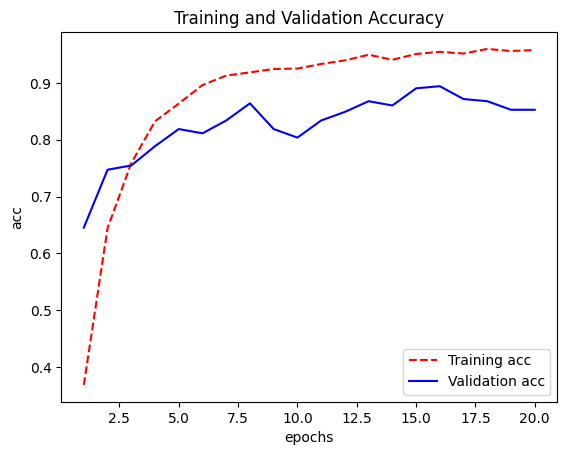

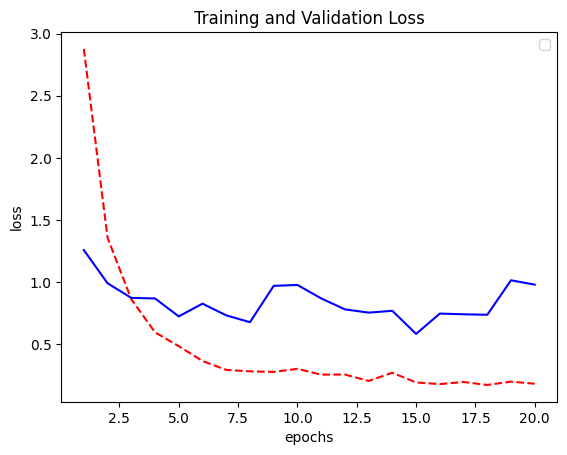

<Figure size 640x480 with 0 Axes>

In [11]:

acc      = history.history[     'accuracy' ]
val_acc  = history.history[ 'val_accuracy' ]
loss     = history.history[    'loss' ]
val_loss = history.history['val_loss' ]

epochs    = range(1,len(acc)+1,1) # obtener número de epochs del eje X

plt.plot  ( epochs,     acc, 'r--', label='Training acc'  )
plt.plot  ( epochs, val_acc,  'b', label='Validation acc')
plt.title ('Training and Validation Accuracy')
plt.ylabel('acc')
plt.xlabel('epochs')

plt.legend()
plt.figure()


plt.plot  ( epochs,     loss, 'r--' )
plt.plot  ( epochs, val_loss ,  'b' )
plt.title ('Training and Validation Loss'   )
plt.ylabel('loss')
plt.xlabel('epochs')

plt.legend()
plt.figure()


In [ ]:
test_lost, test_acc= model.evaluate(test_generator)
print ("Test Accuracy:", test_acc)

9/9 [==============================] - 90s 11s/step - loss: 0.8791 - accuracy: 0.8792


In [ ]:
# Confusion Matrix
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes

# Imprimir el informe de clasificación
print('Classification Report')
print(classification_report(y_true, y_pred))
